In [107]:
import pandas as pd
import bambi as bmb
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

az.style.use("arviz-doc")

#bokeh as backend
az.rcParams["plot.backend"] = "bokeh"
#Display plots as output in Jupyter notebook
az.output_notebook()

df = pd.read_csv('siayaLC50.csv')

df = df.assign(mort72 = df['hr72'] / df['total'])
df.head(3)


Loading BokehJS ...

,replicate,Dose,60min,24hr,48hr,hr72,total,mort72
0,neg control 1,0,0,0,0,0,25,0.00
1,neg control 2,0,0,2,2,2,25,0.08
2,neg control 3,0,0,0,1,1,25,0.04


<Axes: xlabel='Dose', ylabel='mort72'>

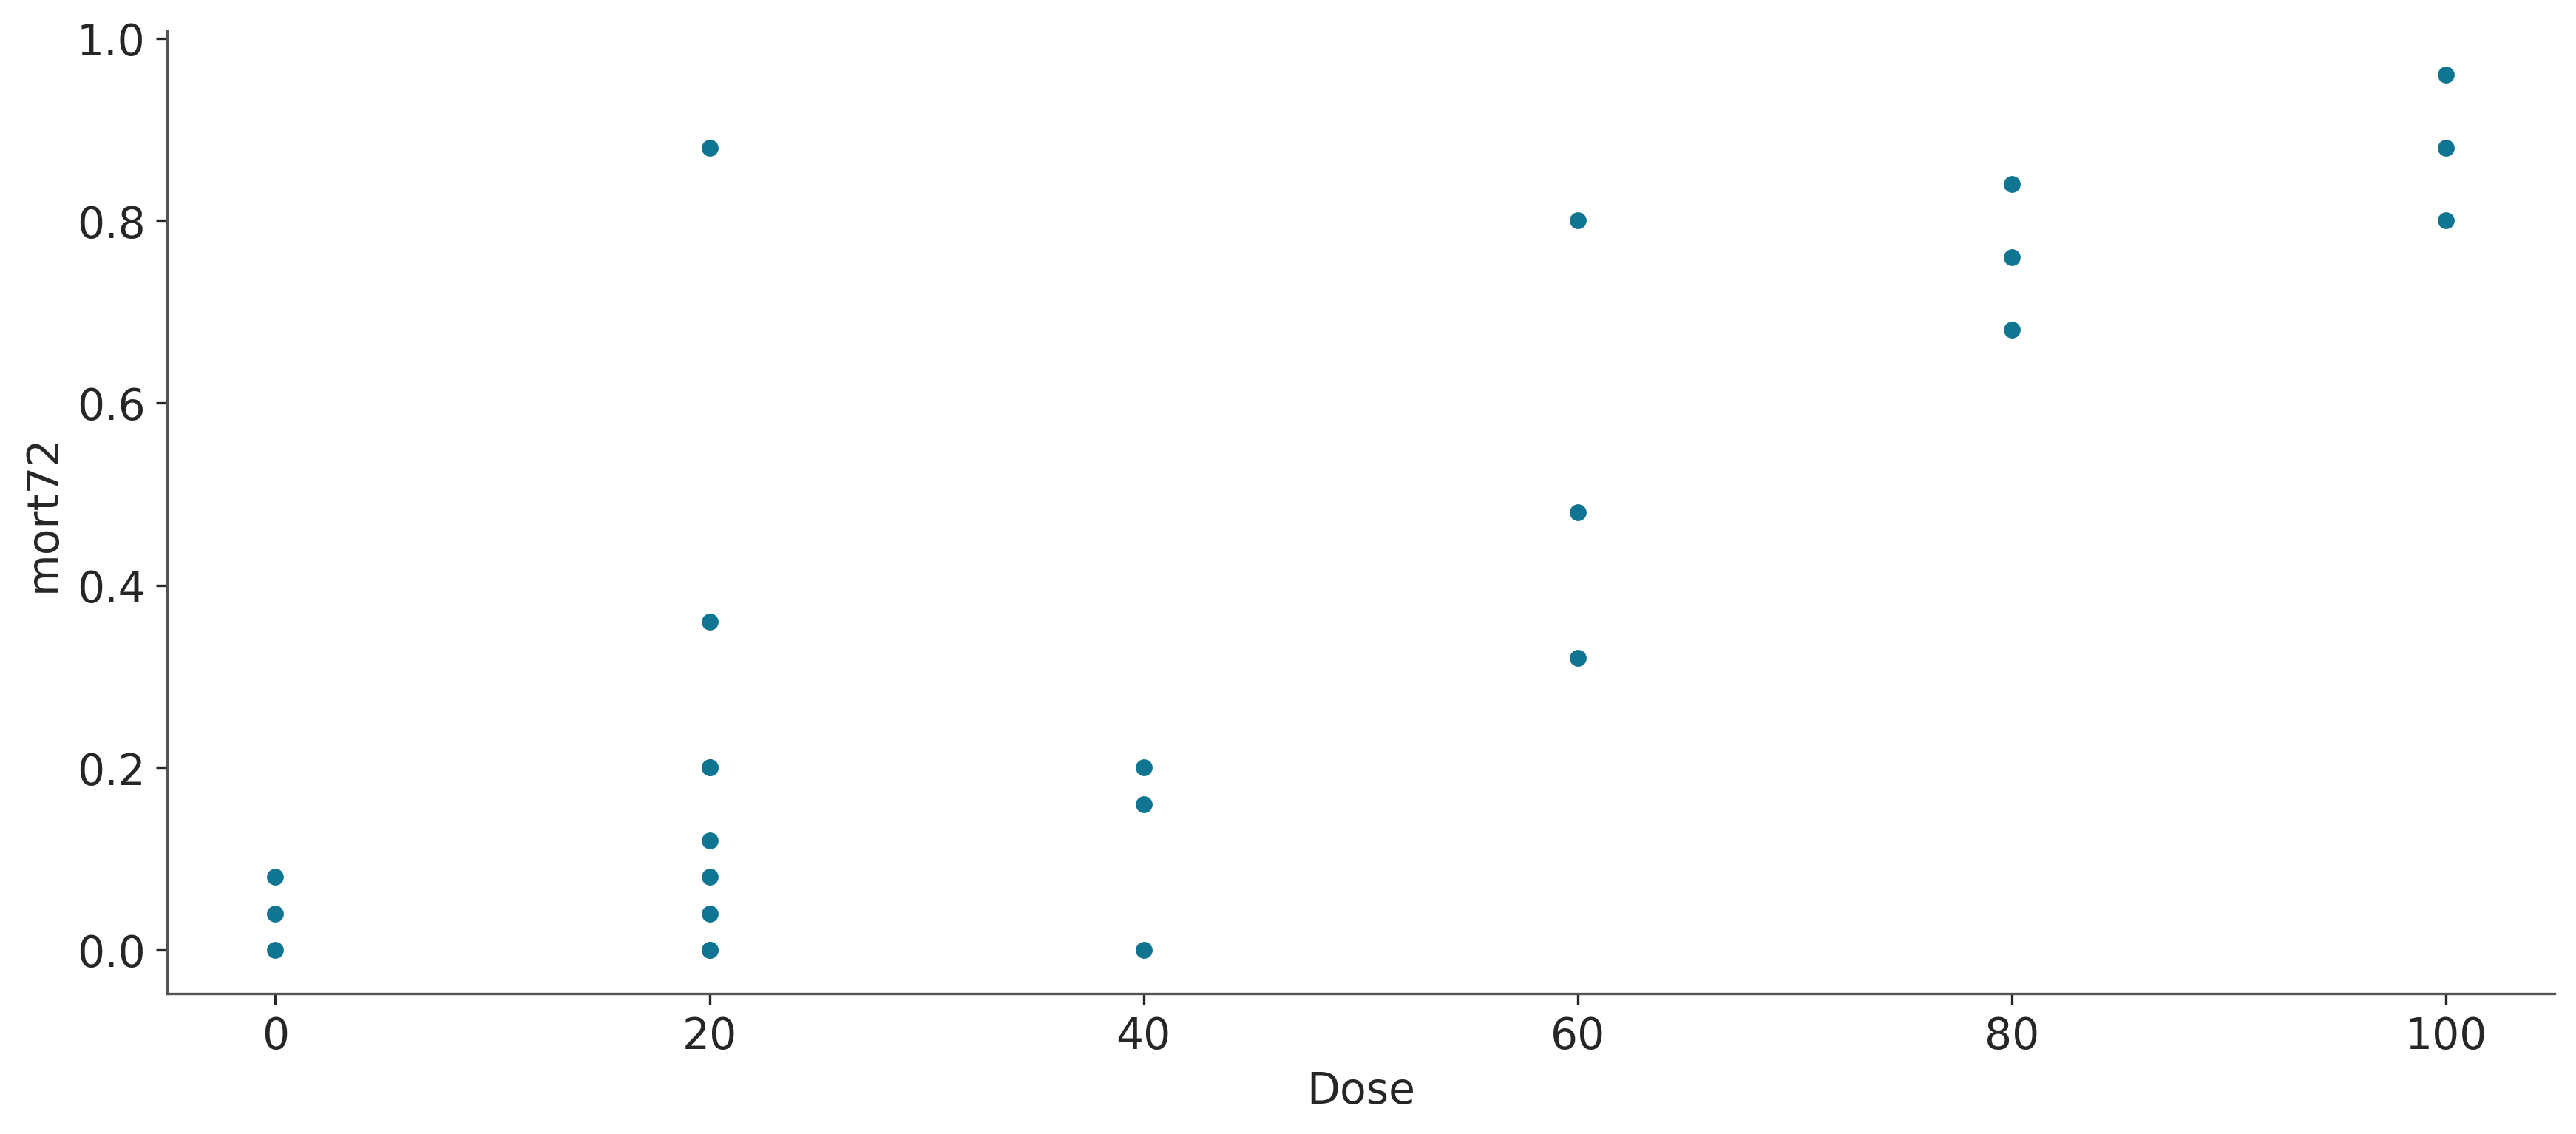

In [109]:
df.plot.scatter(x='Dose', y='mort72')

In [110]:
long_dead = df.take(df.index.repeat(df.hr72)).drop(columns=["total", '60min', '24hr', '48hr', 'mort72'])
long_alive = df.take(df.index.repeat(df.total-df.hr72)).drop(columns=["total", '60min', '24hr', '48hr', 'mort72'])

long_dead
long_alive
model_data=pd.concat([long_alive, long_dead])
print(model_data)
model_data.loc[model_data['hr72'] > 0, 'hr72'] = 1
print(model_data)


        replicate  Dose  hr72
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
..            ...   ...   ...
23          100-3   100    24
23          100-3   100    24
23          100-3   100    24
23          100-3   100    24
23          100-3   100    24

[600 rows x 3 columns]
        replicate  Dose  hr72
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
0   neg control 1     0     0
..            ...   ...   ...
23          100-3   100     1
23          100-3   100     1
23          100-3   100     1
23          100-3   100     1
23          100-3   100     1

[600 rows x 3 columns]


In [123]:
model = bmb.Model("hr72 ~ Dose", model_data, family='bernoulli')
samples = model.fit(draws=1000, chains=4)
model
az.plot_trace(samples)

Modeling the probability that hr72==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Dose]


c:\Users\hartm\OneDrive\Documents\bayes-lc50\.conda\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 442 seconds.


array([[figure(id='p1424', ...), figure(id='p1461', ...)],
       [figure(id='p1498', ...), figure(id='p1535', ...)]], dtype=object)

In [124]:
import bokeh.plotting as bkp

print(samples.posterior)
print(model)

<xarray.Dataset>
Dimensions:    (chain: 4, draw: 1000)
Coordinates:
  * chain      (chain) int32 0 1 2 3
  * draw       (draw) int32 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    Intercept  (chain, draw) float64 0.7587 0.6169 0.5914 ... 0.7437 0.3598
    Dose       (chain, draw) float64 0.02807 0.03243 0.03474 ... 0.03548 0.04383
Attributes:
    created_at:                  2024-12-10T01:30:10.221350
    arviz_version:               0.17.1
    inference_library:           pymc
    inference_library_version:   5.16.1
    sampling_time:               442.0835428237915
    tuning_steps:                1000
    modeling_interface:          bambi
    modeling_interface_version:  0.14.0
       Formula: hr72 ~ Dose
        Family: bernoulli
          Link: p = logit
  Observations: 600
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.1311)
            Dose ~ Normal(mu: 0.0, sigma: 0.0774)
------
* To see a 

In [126]:
import numpy as np
new_data = pd.DataFrame({
    "Dose": np.arange(0, 101)
})

model.predict(samples, data=new_data) #predicted values get stored in samples.p
mort_posterior = az.extract_dataset(samples, num_samples=3000)["p"]
print(mort_posterior)

<xarray.DataArray 'p' (__obs__: 101, sample: 3000)>
array([[0.58671995, 0.61744986, 0.58680923, ..., 0.58563832, 0.65883883,
        0.58238774],
       [0.59518432, 0.62589977, 0.59542506, ..., 0.59373521, 0.66681981,
        0.59242862],
       [0.60359246, 0.63427359, 0.60398247, ..., 0.60178147, 0.67470628,
        0.60239289],
       ...,
       [0.97773234, 0.98200877, 0.97904723, ..., 0.97405643, 0.98460121,
        0.98778551],
       [0.97848211, 0.98263266, 0.97976616, ..., 0.97488882, 0.98513341,
        0.98827542],
       [0.97920717, 0.98323529, 0.98046091, ..., 0.97569518, 0.98564747,
        0.98874591]])
Coordinates:
  * __obs__  (__obs__) int32 0 1 2 3 4 5 6 7 8 9 ... 92 93 94 95 96 97 98 99 100
  * sample   (sample) object MultiIndex
  * chain    (sample) int32 3 2 2 0 3 3 1 0 3 3 1 2 ... 1 0 1 3 1 2 2 3 1 1 1 0
  * draw     (sample) int32 526 717 873 32 883 857 614 ... 810 344 6 840 789 454


C:\Users\hartm\AppData\Local\Temp\ipykernel_15952\573450230.py:7: FutureWarning: extract_dataset has been deprecated, please use extract
  mort_posterior = az.extract_dataset(samples, num_samples=3000)["p"]


Default computed for conditional variable: Dose


(<Figure size 840x360 with 1 Axes>,
 array([<Axes: xlabel='Dose', ylabel='hr72'>], dtype=object))

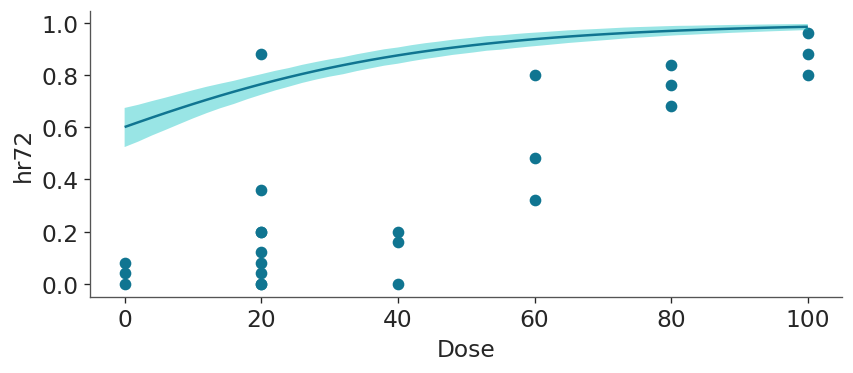

In [129]:
fig, ax = plt.subplots(figsize=(7, 3), dpi=120)
plt.scatter(df['Dose'], df['mort72'])
bmb.interpret.plot_predictions(model, samples, "Dose", ax=ax)